In [16]:
import sys
sys.executable

'C:\\Users\\vai11025\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-covid-19-env\\python.exe'

In [17]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat    #for loading model matlab file

In [18]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [19]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO


In [20]:
beta  = 0.01566          # infection rate 
gamma = 1./7             # recovery rate 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gamma*L0

L[0:M, M:2*M]   = fsa*alpha*beta/gamma*L0

L[M:2*M, 0:M]   =    ((1-alpha)*beta/gamma)*L0

L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gamma)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (2.12728921561319+0j)


In [21]:
# duration of simulation and data file
# tf - no of days starting from 4 march 2020, Nf - no of prediction data points, within 41 days.
#Tf=21*2-1; 
Tf=100
Nf=100; filename='this.mat'

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# initiate model
model = pyross.models.SIR(alpha, beta, gamma, fsa, M, Ni)

# run model
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

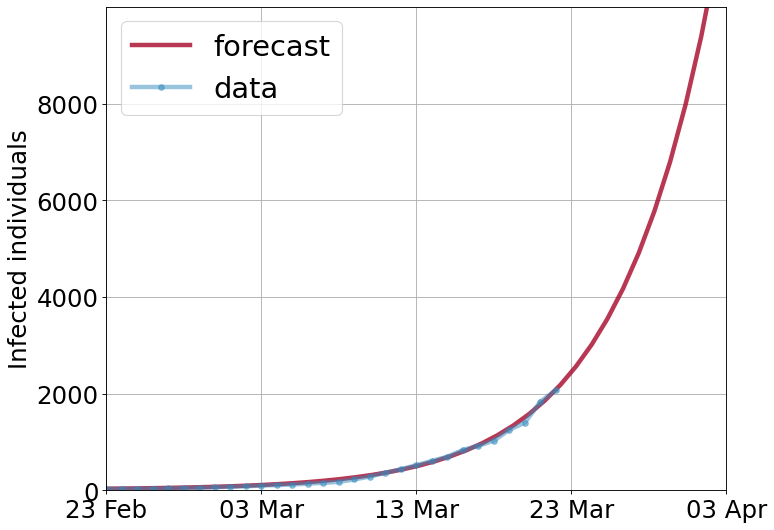

In [22]:
data=loadmat(filename); 
t = data['t'][0];
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
        
        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

plt.xticks(np.arange(0, Tf, 10), ('23 Feb', '03 Mar', '13 Mar', '23 Mar', '03 Apr', '13 Apr'));
my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)

day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 40); plt.ylim(0, 9999);

In [8]:
main_table = pd.DataFrame(data=IC, columns=["no of predicted cases"])
main_table['date'] = pd.date_range(start='2/23/2020', periods=len(main_table), freq='D')
main_table['no of predicted cases'] = main_table['no of predicted cases'].apply(np.int64)


true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

final_table = pd.concat([main_table, true_no_of_cases], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'Lag_adjusted_final_table_dataframe_Model_A.xlsx', index = False, header=True)

final_table.head()

,date,no of actual cases,no of predicted cases
0,2020-02-23,28.0,31
1,2020-02-24,30.0,34
2,2020-02-25,31.0,38
3,2020-02-26,34.0,43
4,2020-02-27,39.0,48


In [23]:
'''
from IPython.display import display
from arcgis.gis import GIS
import os
username = "demos_deldev"
password = "DelDevs12"
gis = GIS("http://deldev.maps.arcgis.com", username, password)


table_file = 'Lag_adjusted_final_table_dataframe_Model_A.xlsx'



online_table= gis.content.add({}, table_file)


folder_name='vbhv_'
folder = gis.content.create_folder(folder_name)
print(folder)
online_table.move(folder)

#model_initial = online_table.publish()
#model_initial.move(folder)
'''

'\nfrom IPython.display import display\nfrom arcgis.gis import GIS\nimport os\nusername = "demos_deldev"\npassword = "DelDevs12"\ngis = GIS("http://deldev.maps.arcgis.com", username, password)\n\n\ntable_file = \'Lag_adjusted_final_table_dataframe_Model_A.xlsx\'\n\n\n\nonline_table= gis.content.add({}, table_file)\n\n\nfolder_name=\'vbhv_\'\nfolder = gis.content.create_folder(folder_name)\nprint(folder)\nonline_table.move(folder)\n\n#model_initial = online_table.publish()\n#model_initial.move(folder)\n'

In [24]:
#With lockdown simulations

In [25]:
#one lockdown

beta  = 0.01566         # contact rate parameter
gamma = 1./7            # recovery rate 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


model = pyross.models.SIR(alpha, beta, gamma, fsa, M, Ni)

# the contact matrix is time-dependent
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=100;  Nf=100; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

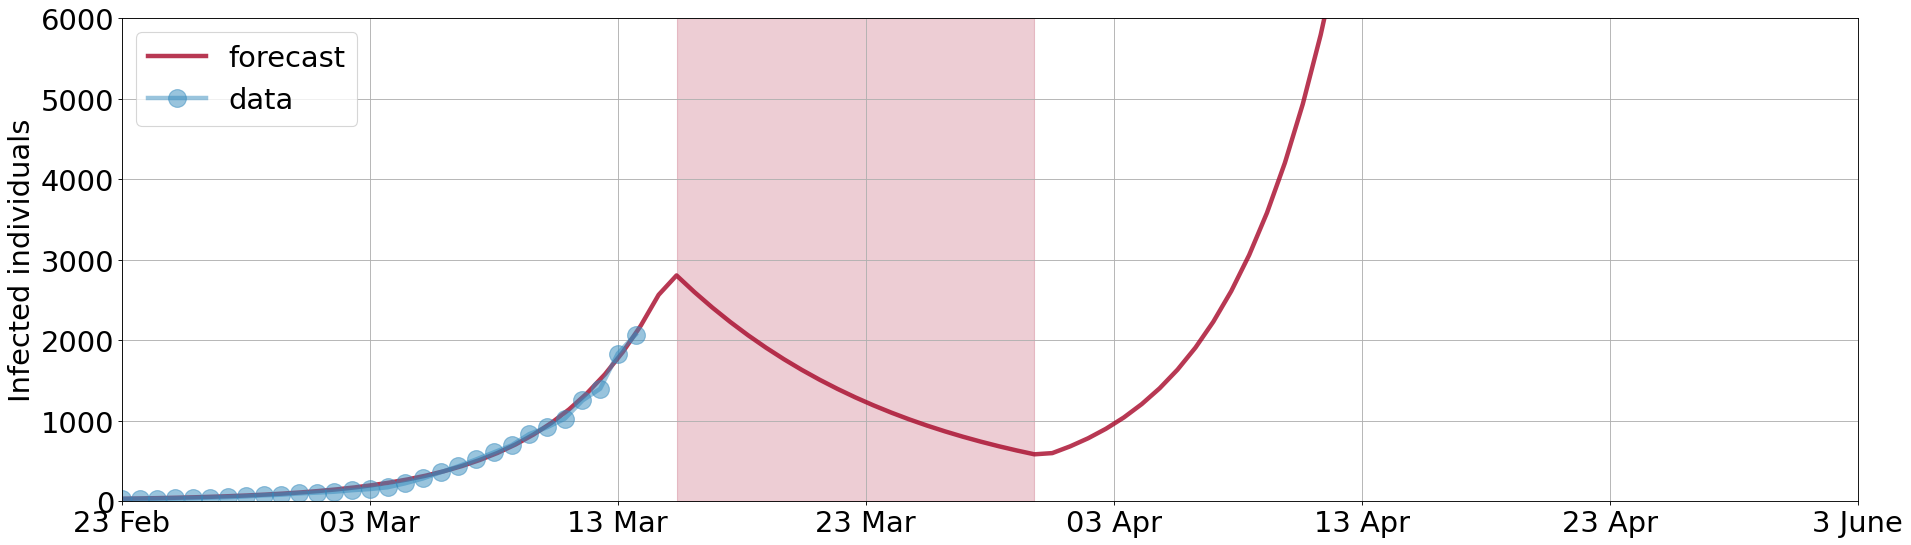

In [26]:
data=loadmat(filename)
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t'][0]

fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('23 Feb', '03 Mar', '13 Mar', '23 Mar', '03 Apr', '13 Apr', '23 Apr', '3 June'));
t1=int(Nf/9)
plt.fill_between(t[((3*(t1))-2):((6*(t1))-14)], 0, 6000, color="#A60628", alpha=0.2)




my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 6000); plt.xlim(0, 98);

In [27]:
true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

main_table_all_data1 = pd.DataFrame(data=IC, columns=["pre-lockdown: predicted cases"])
main_table_all_data1['pre-lockdown: predicted cases'] = main_table_all_data1['pre-lockdown: predicted cases'].apply(np.int64)
main_table_all_data1[31:]=None

main_table_all_data1['date'] = pd.date_range(start='2/23/2020', periods=len(main_table_all_data1), freq='D')

main_table_lockdown = pd.DataFrame(data=IC, columns=["lockdown: predicted cases"])
main_table_lockdown['lockdown: predicted cases'] = main_table_lockdown['lockdown: predicted cases'].apply(np.int64)
main_table_lockdown[0:31]=None
main_table_lockdown[52:]=None

main_table_all_data2 = pd.DataFrame(data=IC, columns=["post-lockdown: predicted cases"])
main_table_all_data2['post-lockdown: predicted cases'] = main_table_all_data2['post-lockdown: predicted cases'].apply(np.int64)
main_table_all_data2[0:52]=None




final_table = pd.concat([true_no_of_cases, main_table_lockdown, main_table_all_data1, main_table_all_data2], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col] 

#final_table=final_table.sort_values(by=['no of predicted cases in lockdown'])



final_table.to_csv (r'Lag_adjusted_final_table_dataframe_Model_B.csv', index = False, header=True)

final_table.head()

,date,post-lockdown: predicted cases,no of actual cases,lockdown: predicted cases,pre-lockdown: predicted cases
0,2020-02-23,NaN,28.0,NaN,31.0
1,2020-02-24,NaN,30.0,NaN,34.0
2,2020-02-25,NaN,31.0,NaN,38.0
3,2020-02-26,NaN,34.0,NaN,43.0
4,2020-02-27,NaN,39.0,NaN,48.0


In [15]:

from IPython.display import display
from arcgis.gis import GIS
import os
username = "demos_deldev"
password = "DelDevs12"
gis = GIS("http://deldev.maps.arcgis.com", username, password)


table_file = 'Lag_adjusted_final_table_dataframe_Model_B.xlsx'



online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)


folder_name='vbhv_'
online_table.move(folder_name)
#model_initial = online_table.publish()
#model_initial.move(folder_name)


'\nfrom IPython.display import display\nfrom arcgis.gis import GIS\nimport os\nusername = "demos_deldev"\npassword = "DelDevs12"\ngis = GIS("http://deldev.maps.arcgis.com", username, password)\n\n\ntable_file = \'Lag_adjusted_final_table_dataframe_Model_B.xls\'\n\n\n\nonline_table= gis.content.add({\'type\': \'Microsoft Excel\'}, table_file)\n\n\nfolder_name=\'vbhv_\'\nonline_table.move(folder_name)\n#model_initial = online_table.publish()\n#model_initial.move(folder_name)\n'

In [16]:
## Three closures

In [28]:

beta  = 0.01566         # contact rate parameter
gamma = 1./7            # recovery rate 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)



def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    elif 52<=t<57:
        xx = C
    elif 57<=t<85:
        xx = CH
    elif 85<=t<90:
        xx = C
    else:
        xx = CH
    return xx

# start simulation
Tf=300;  Nf=300; filename='this.mat'
model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

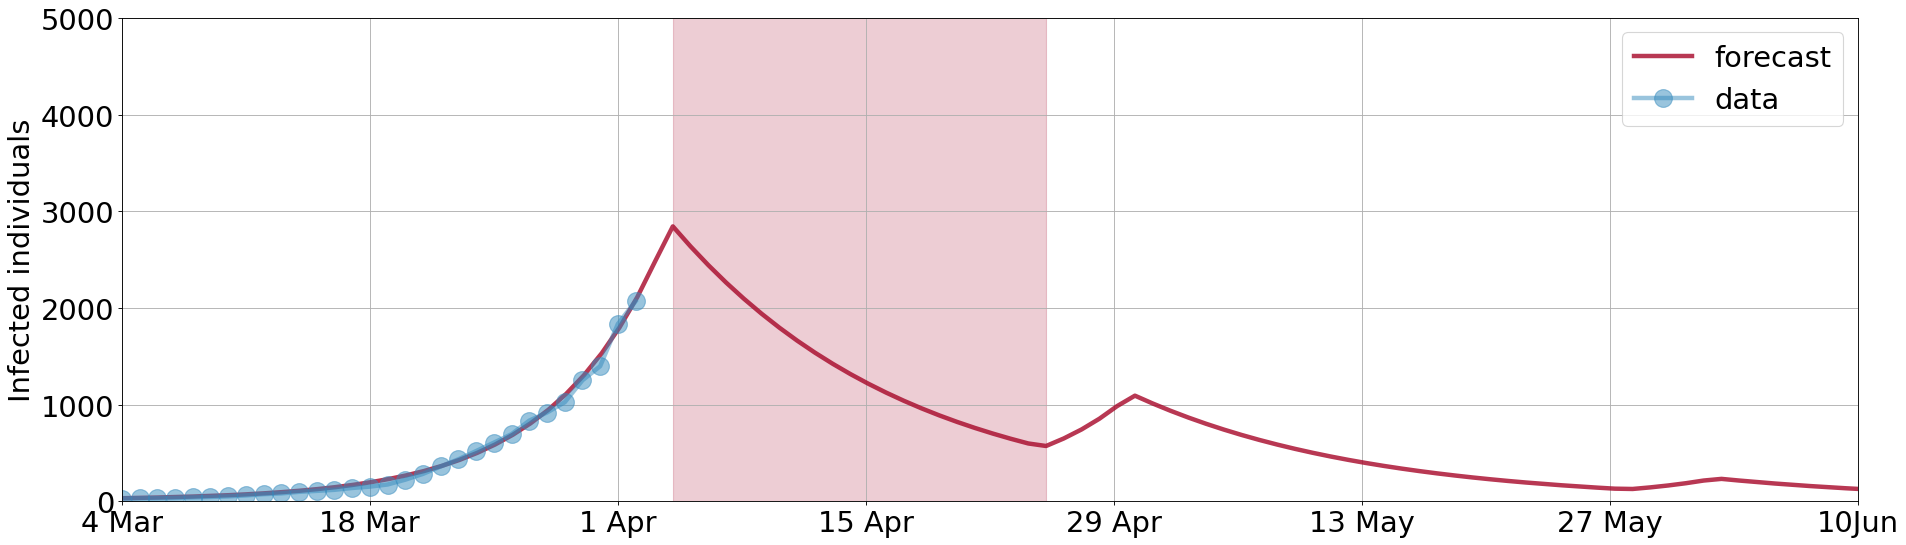

In [29]:
data=loadmat(filename)

IC  = np.zeros((Nf))
SC  = np.zeros((Nf))
t = data['t'][0]

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

    
  
fig =plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]  

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/27)
plt.fill_between(t[((3*(t1))-2):((6*(t1))-13)], 0, 6000, color="#A60628", alpha=0.2)



plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 5000);


In [30]:
true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

main_table_all_data1 = pd.DataFrame(data=IC, columns=["pre-lockdown 1: predicted cases"])
main_table_all_data1['pre-lockdown 1: predicted cases'] = main_table_all_data1['pre-lockdown 1: predicted cases'].apply(np.int64)
main_table_all_data1[31:]=None

main_table_all_data1['date'] = pd.date_range(start='2/23/2020', periods=len(main_table_all_data1), freq='D')

main_table_lockdown1 = pd.DataFrame(data=IC, columns=["lockdown 1: predicted cases"])
main_table_lockdown1['lockdown 1: predicted cases'] = main_table_lockdown1['lockdown 1: predicted cases'].apply(np.int64)
main_table_lockdown1[0:31]=None
main_table_lockdown1[52:]=None

main_table_all_data2 = pd.DataFrame(data=IC, columns=["post-lockdown 1: predicted cases"])
main_table_all_data2['post-lockdown 1: predicted cases'] = main_table_all_data2['post-lockdown 1: predicted cases'].apply(np.int64)
main_table_all_data2[0:52]=None
main_table_all_data2[57:]=None

main_table_lockdown2 = pd.DataFrame(data=IC, columns=["lockdown 2: predicted cases"])
main_table_lockdown2['lockdown 2: predicted cases'] = main_table_lockdown2['lockdown 2: predicted cases'].apply(np.int64)
main_table_lockdown2[0:57]=None
main_table_lockdown2[85:]=None

main_table_all_data3 = pd.DataFrame(data=IC, columns=["post-lockdown 2: predicted cases"])
main_table_all_data3['post-lockdown 2: predicted cases'] = main_table_all_data3['post-lockdown 2: predicted cases'].apply(np.int64)
main_table_all_data3[0:85]=None
main_table_all_data3[90:]=None

main_table_lockdown3 = pd.DataFrame(data=IC, columns=["lockdown 3: predicted cases"])
main_table_lockdown3['lockdown 3: predicted cases'] = main_table_lockdown3['lockdown 3: predicted cases'].apply(np.int64)
main_table_lockdown3[0:90]=None
main_table_lockdown3[108:]=None


main_table_all_data4 = pd.DataFrame(data=IC, columns=["post-lockdown 3: predicted cases"])
main_table_all_data4['post-lockdown 3: predicted cases'] = main_table_all_data4['post-lockdown 3: predicted cases'].apply(np.int64)
main_table_all_data4[0:108]=None




final_table = pd.concat([true_no_of_cases, main_table_lockdown1, main_table_all_data1, main_table_all_data2, main_table_lockdown2, main_table_all_data3, main_table_lockdown3, main_table_all_data4], axis=1, sort=False)


col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'Lag_adjusted_final_table_dataframe_Model_C.xlsx', index = False, header=True)

final_table.head()


,date,post-lockdown 1: predicted cases,lockdown 2: predicted cases,post-lockdown 2: predicted cases,lockdown 3: predicted cases,post-lockdown 3: predicted cases,no of actual cases,lockdown 1: predicted cases,pre-lockdown 1: predicted cases
0,2020-02-23,NaN,NaN,NaN,NaN,NaN,28.0,NaN,31.0
1,2020-02-24,NaN,NaN,NaN,NaN,NaN,30.0,NaN,34.0
2,2020-02-25,NaN,NaN,NaN,NaN,NaN,31.0,NaN,38.0
3,2020-02-26,NaN,NaN,NaN,NaN,NaN,34.0,NaN,43.0
4,2020-02-27,NaN,NaN,NaN,NaN,NaN,39.0,NaN,48.0


In [32]:

from IPython.display import display
from arcgis.gis import GIS
import os
username = "demos_deldev"
password = "DelDevs12"
gis = GIS("http://deldev.maps.arcgis.com", username, password)


table_file = 'Lag_adjusted_final_table_dataframe_Model_C1111.xlsx'



online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)

folder_name='vbhv14_csv_hosted'
online_table.move(folder_name)

model_initial = online_table.publish(overwrite=True)
model_initial.move(folder_name)


{'success': True,
 'itemId': '8d58f2c998884d1aa373b83bc1bf8b6c',
 'owner': 'demos_deldev',
 'folder': 'd75a33933159496b9fc2c48da472a584'}

In [34]:

from IPython.display import display
from arcgis.gis import GIS
import os
username = "demos_deldev"
password = "DelDevs12"
gis = GIS("http://deldev.maps.arcgis.com", username, password)


table_file = 'Lag_adjusted_final_table_dataframe_Model_C111122.xlsx'



online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)

folder_name='vbhv14_csv_hosted'
online_table.move(folder_name)

model_initial = online_table.publish()
model_initial.move(folder_name)


Item already exists in target folder


RuntimeError: Item already exists in target folder
(Error Code: 500)

In [ ]:

'''